In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parasitized_contrast = os.listdir('./Parasitized_enlarge/contrast/') 
uninfected_contrast = os.listdir('./Uninfected_enlarge/contrast/') 
data = []
labels = []

In [3]:
for positive_data in parasitized_contrast:
    if positive_data == "Thumbs.db":
        continue
    image = Image.open("./Parasitized_enlarge/contrast/" + positive_data)
    image = image.resize((71, 71))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)

    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(1)
    labels.append(1)
    labels.append(1)
    labels.append(1)

for negative_data in uninfected_contrast:
    if negative_data == "Thumbs.db":
        continue
    image = Image.open("./Uninfected_enlarge/contrast/" + negative_data)
    image = image.resize((71, 71))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)
    
    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(0)
    labels.append(0)
    labels.append(0)
    labels.append(0)

In [4]:
Data = np.array(data)
Labels = np.array(labels)

np.save('Data' , Data)
np.save('Labels' , Labels)
print('Data : {} | labels : {}'.format(Data.shape , Labels.shape))
from sklearn.utils import shuffle
Data, Labels = shuffle(Data, Labels)
Data = Data.astype(np.float32)
Data = Data / 255
Labels = Labels.astype(np.int32)
from sklearn.model_selection import train_test_split
ntrain = int(len(Data)*0.8)
X_test = Data[ntrain:]
y_test = Labels[ntrain:]
X_train, X_val, y_train, Y_val = train_test_split(Data[0:ntrain], Labels[0:ntrain], test_size=0.2, random_state = 40)

Data : (110232, 71, 71, 3) | labels : (110232,)


In [6]:
from keras.applications import xception
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras import regularizers
def xception_model(input_shape= (71,71,3)):
    model_xception = xception.Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in model_xception.layers:
        layer.trainable = True
    last = model_xception.output
    x = Flatten()(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=model_xception.input, outputs=x)
    
    return model

In [7]:
model = xception_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer = Adam(0.0001), metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 71, 71, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [8]:
history = model.fit(X_train,y_train, validation_data=(X_val, Y_val),epochs=30,batch_size=100,verbose=True)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 70548 samples, validate on 17637 samples
Epoch 1/30
70548/70548 [==============================] - 180s 3ms/step - loss: 0.1227 - acc: 0.9561 - val_loss: 0.0814 - val_acc: 0.9711
Epoch 2/30
70548/70548 [==============================] - 170s 2ms/step - loss: 0.0656 - acc: 0.9760 - val_loss: 0.0741 - val_acc: 0.9730
Epoch 3/30
70548/70548 [==============================] - 170s 2ms/step - loss: 0.0403 - acc: 0.9856 - val_loss: 0.0935 - val_acc: 0.9712
Epoch 4/30
70548/70548 [==============================] - 170s 2ms/step - loss: 0.0254 - acc: 0.9910 - val_loss: 0.1026 - val_acc: 0.9760
Epoch 5/30
70548/70548 [==============================] - 170s 2ms/step - loss: 0.0170 - acc: 0.9937 - val_loss: 0.0892 - val_acc: 0.9770
Epoch 6/30
70548/70548 [==============================] - 170s 2ms/step - loss: 0.0147 - acc: 0.9949 - val_loss: 0.1112 - val_acc: 0.9748
Epoch 7/30
70548/70548 [==============================] - 170s 2ms/step - loss: 0.0104 - acc: 0.9963 - val_loss: 0.1383 - 

Test loss: 0.15652591485653392
Test accuracy: 0.9756883022633465


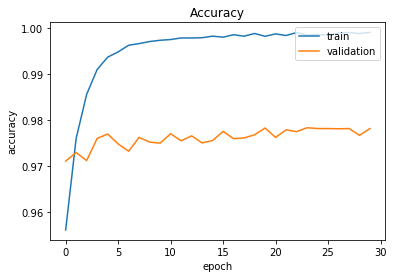

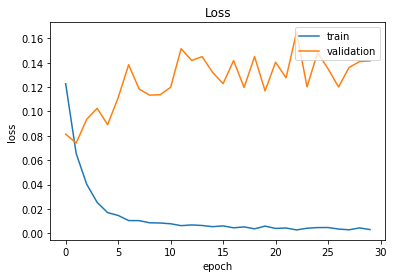

In [9]:
print("Test loss: " + str(score[0]))
print("Test accuracy: " + str(score[1]))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()